# Comparing two- and three-point correlations

Demonstrate the difference between two- and three-point covariance matrices. As an example we use "signs" and "change indicators" as time series. This problem emerges when estimating kernels for certain linear models. More precisely, it is part of the HDIM2 calibration procedure described in:
      
> Patzelt, F. and Bouchaud, J-P. (2017):
> Nonlinear price impact from linear models.
> *Journal of Statistical Mechanics.*
> Preprint at arXiv:1706.04163.

The notation is consistent with that paper and the related literature. To just understand the code below, consider a series of signs `s` $\in [-1,1]$ and change indicators `c` $\in [n,c]$. We use `0` and `1`to represent no change (n) and change (c).

Below we calculate two-point correlation matrices 
$C_{\pi \pi' \pi''}(\ell,j)$ was approximated by the two-point cross-correlation $C_{\pi \pi'}(j) := \langle \delta_{\pi(t)\, \pi}\, \epsilon(t)\: \delta_{\pi(t-j)\, \pi'}\, \epsilon(t-j) \rangle$

In [1]:
# external dependencies
# ---------------------
import numpy as np

# set the plotting
import matplotlib
matplotlib.use('nbagg') # change according to your needs: agg, tkagg, ...
import matplotlib.pyplot as plt
plt.ion()

# import noise generator
from colorednoise import powerlaw_psd_gaussian

In [2]:
import scorr

### Generate power-law correlated order-flow
Cross-correlations e.g. from returns to later signs are neglected. The purpose here is a minimal demo and not to generate the most realistic order-flows possible.

In [3]:
# autocorrelation exponents
gamma_s = 0.5   # ... of the signs
gamma_c = 0.25  # ... of the price-change indicator
# number of time steps
steps = 10**5

In [4]:
# signs
s = np.sign(powerlaw_psd_gaussian(1-gamma_s, steps)).astype(int)
# change indicator
c = (powerlaw_psd_gaussian(1-gamma_c, steps) > 0.5)

### calculate covariances

In [5]:
# Here we demonstrate the usage for propagator model calibration. 
# The default parameters are chosen for general usage, where one would
# likely want to subtract the mean signal and to normalise to one for zero lag.
# We therefore change these settings.
cvars = {'norm': 'cov', 'subtract_mean': False}

In [6]:
# sign autocorvariance
# --------------------
sacorr = scorr.acorr(s, **cvars)
# output is c(l = 0, 1, 2, ..., L, -L, ... -1)

In [7]:
# two-point correlations
# --------------------------

sc = s * c
sn = s * ~c
matrix_maxlag = 2**4 # short maximum lag for better visibility in plot below
scl = 1.
#scl = c.mean() # optional scaling factor

cccorr = scl * scorr.acorr(sc, **cvars)
nncorr = scl * scorr.acorr(sn, **cvars) 
nccorr = scl * scorr.xcorr(sc, sn, **cvars)
cncorr = scl * scorr.xcorr(sn, sc, **cvars)

# convert to matrix form
Ccc = scorr.corr_mat(cccorr, maxlag=matrix_maxlag)
Cnn = scorr.corr_mat(nncorr, maxlag=matrix_maxlag)
Cnc = scorr.corr_mat(nccorr, maxlag=matrix_maxlag)
Ccn = scorr.corr_mat(cncorr, maxlag=matrix_maxlag)

In [8]:
# triple correlations (always matrics)
# ------------------------------------
Cccc = scorr.x3corr(c, sc, sc, nfft=matrix_maxlag, **cvars)
Cnnc = scorr.x3corr(c, sn, sn, nfft=matrix_maxlag, **cvars)
Ccnc = scorr.x3corr(c, sc, sn, nfft=matrix_maxlag, **cvars)
Cncc = Ccnc.T

### plot

<IPython.core.display.Javascript object>


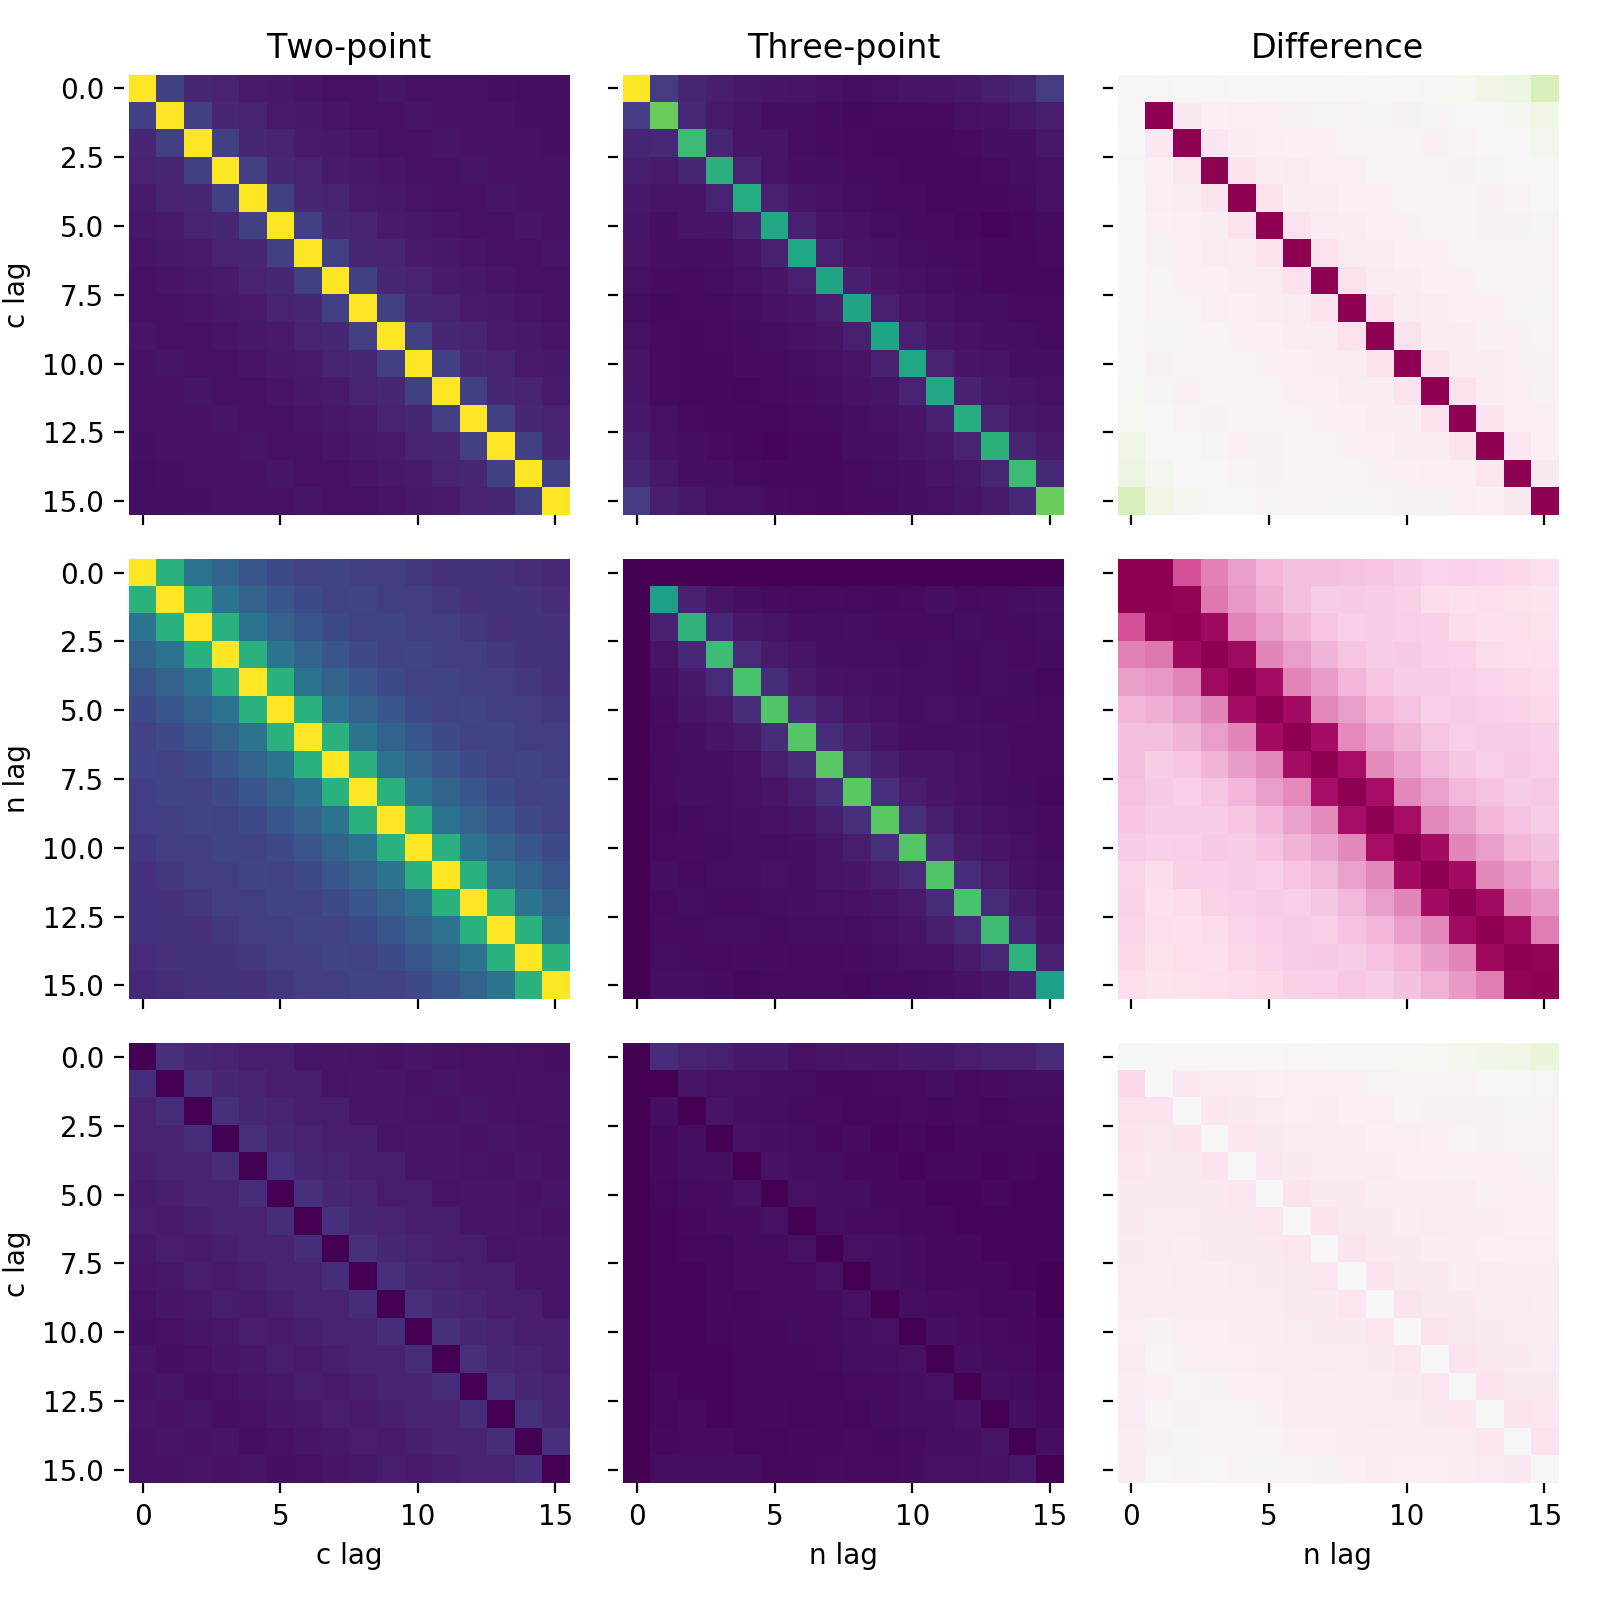

In [9]:
# create figure
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8,8))

# color scale
# 1:  maximum saturation = largest observation
# <1: better contrast for small values (peaks are cropped)
# try to play with the scale to really see the sometimes asymmetric differences
color_scale = .75

# imshow options for positive correlations
ikwc = {
    'vmin': 0, 
    'vmax': color_scale * max(Ccc.max(), Cccc.max()), 
    'interpolation':None, 
    'cmap': 'viridis',
    'aspect':'equal'
}
# ... for differences
emax = color_scale * np.abs(Cccc - Ccc).max()
ikwe = {
    'vmin': -emax, 
    'vmax': emax, 
    'cmap': 'PiYG',
    'interpolation':None, 
    'aspect':'equal'
}

# plot
ax[0,0].set_title('Two-point')
ax[0,0].imshow(Ccc,   **ikwc)
ax[0,1].imshow(Cccc,  **ikwc)
ax[0,2].imshow(Cccc - Ccc, **ikwe)

ax[0,1].set_title('Three-point')
ax[1,0].imshow(Cnn,   **ikwc)
ax[1,1].imshow(Cnnc,  **ikwc)
ax[1,2].imshow(Cnnc - Cnn, **ikwe)

ax[0,2].set_title('Difference')
ax[2,0].imshow(Cnc,   **ikwc)
ax[2,1].imshow(Cncc,  **ikwc)
ax[2,2].imshow(Cncc - Cnc, **ikwe)

# format plot
xindicators = ['c', 'n', 'n']
yindicators = ['c', 'n', 'c']

for a, i in zip(ax[:,0], yindicators):
    a.set_ylabel(i + ' lag')
for a, i in zip(ax[-1,:], xindicators):
    a.set_xlabel(i + ' lag')
for a in ax.flatten():
    a.set_frame_on(False)

plt.tight_layout()